<a href="https://colab.research.google.com/github/JairLeal157/MLDiabetes/blob/main/Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import joblib


**1. Importacion de datos y exploracion basica de los datos**

importamos los datos e imprimiremos sus características junto a la forma del compartamiento de cada una de sus variables y sus correlacion


In [22]:
# Importamos los datos de csv en un dataframe de pandas
data= pd.read_csv("diabetes_prediction_dataset.csv")

# Columnas del dataframe
data.info()

# Ejemplo de los datos
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


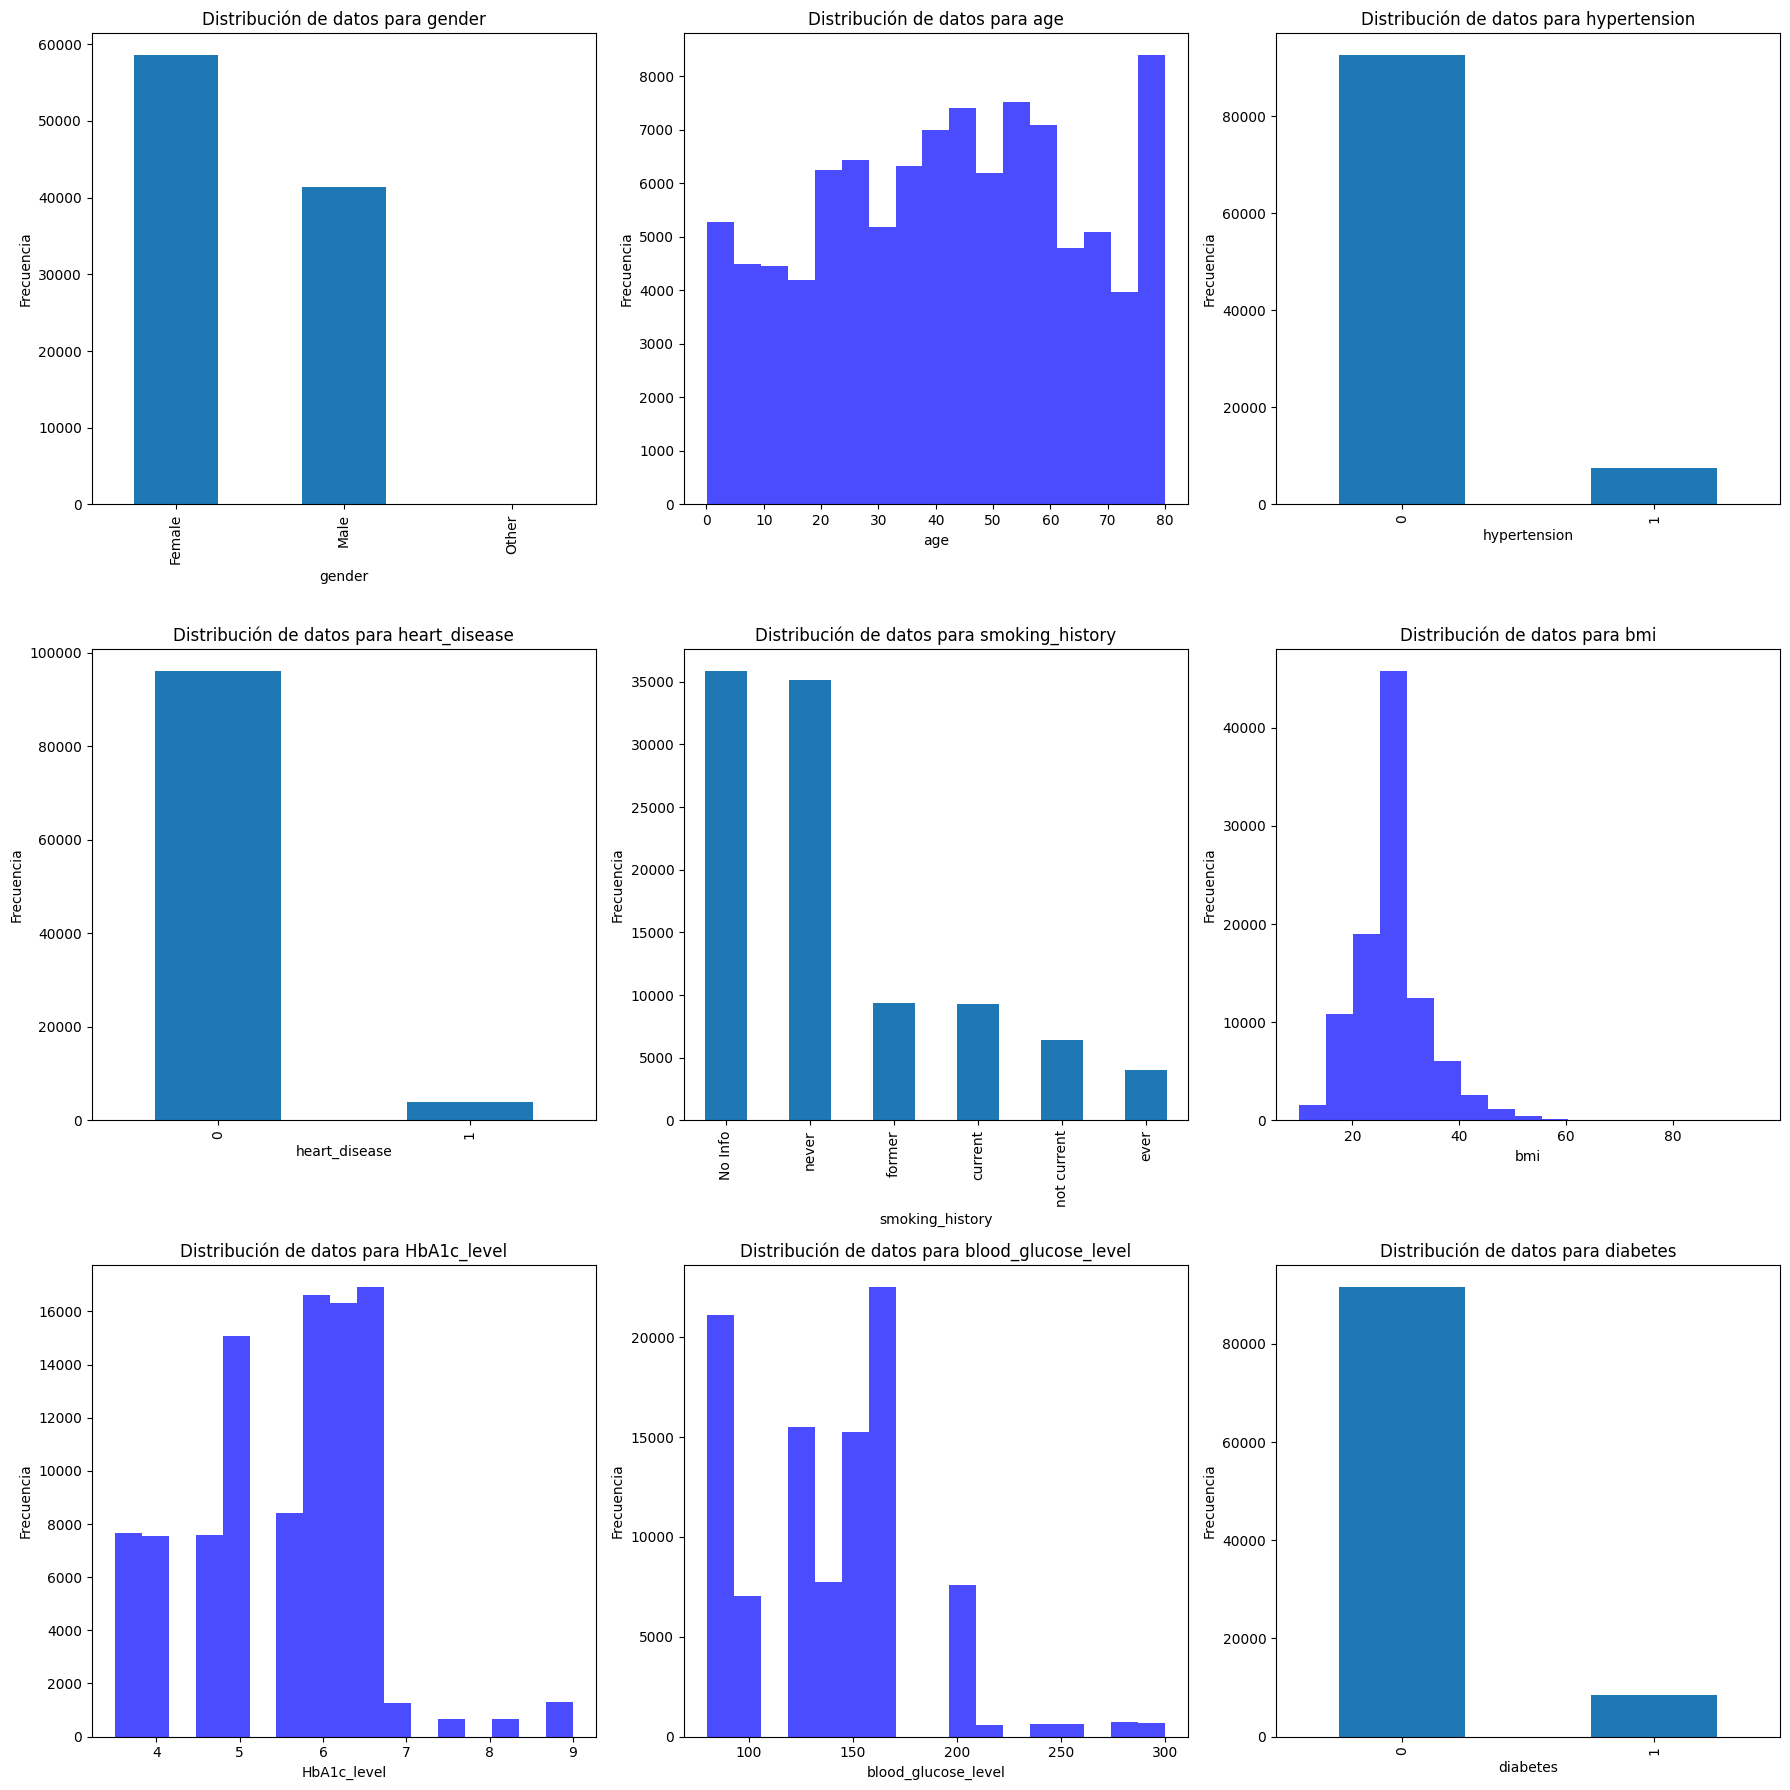

In [23]:
fig, axes = plt.subplots(3,3, figsize=(18,18))
axes = axes.ravel()
for i, columna in enumerate(data):
    ax = axes[i]
    if columna in ['gender','hypertension','heart_disease','smoking_history', 'diabetes']:     
        data[columna].value_counts().plot(kind='bar', ax = ax)
    else:
        N = len(data[columna])
        num_bins = int(1 + np.log2(N))
        data[columna].plot(kind='hist', bins=num_bins, color='blue', alpha=0.7, ax = ax)

    ax.set_title(f'Distribución de datos para {columna}')
    ax.set_xlabel(columna)
    ax.set_ylabel('Frecuencia')

# Mostrar el gráfico en pantalla
plt.tight_layout()
plt.show()

**2. Tratamiento de Datos: Conversión de Datos Categóricos a Numéricos**

Convertiremos datos categóricos en representaciones numéricas para su uso en modelos de aprendizaje automático.

In [24]:
# Creamos un encoder para la columna 'gender'
gender_encoder = OneHotEncoder(sparse=False)
gender_encoded = gender_encoder.fit_transform(data[['gender']])

# Creamos un encoder para la columna 'smoking_history'
smoking_history_encoder = OneHotEncoder(sparse=False)
smoking_history_encoded = smoking_history_encoder.fit_transform(data[['smoking_history']])

# Convertimos en DataFrames
gender_encoded_df = pd.DataFrame(gender_encoded, columns=gender_encoder.get_feature_names_out(['gender']))
smoking_history_encoded_df = pd.DataFrame(smoking_history_encoded, columns=smoking_history_encoder.get_feature_names_out(['smoking_history']))

# Eliminamos las columnas originales
data = data.drop(['gender', 'smoking_history'], axis=1)

# Concatenamos los DataFrames codificados 
data = pd.concat([data, gender_encoded_df, smoking_history_encoded_df], axis=1)

# Ejemplo de los datos
display(data.head())



/home/estudiantes/jair.leal/Documents/MLDiabetes/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/estudiantes/jair.leal/Documents/MLDiabetes/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,54.0,0,0,27.32,6.6,80,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,28.0,0,0,27.32,5.7,158,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,36.0,0,0,23.45,5.0,155,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,76.0,1,1,20.14,4.8,155,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**2.1 Matriz de correlacion**


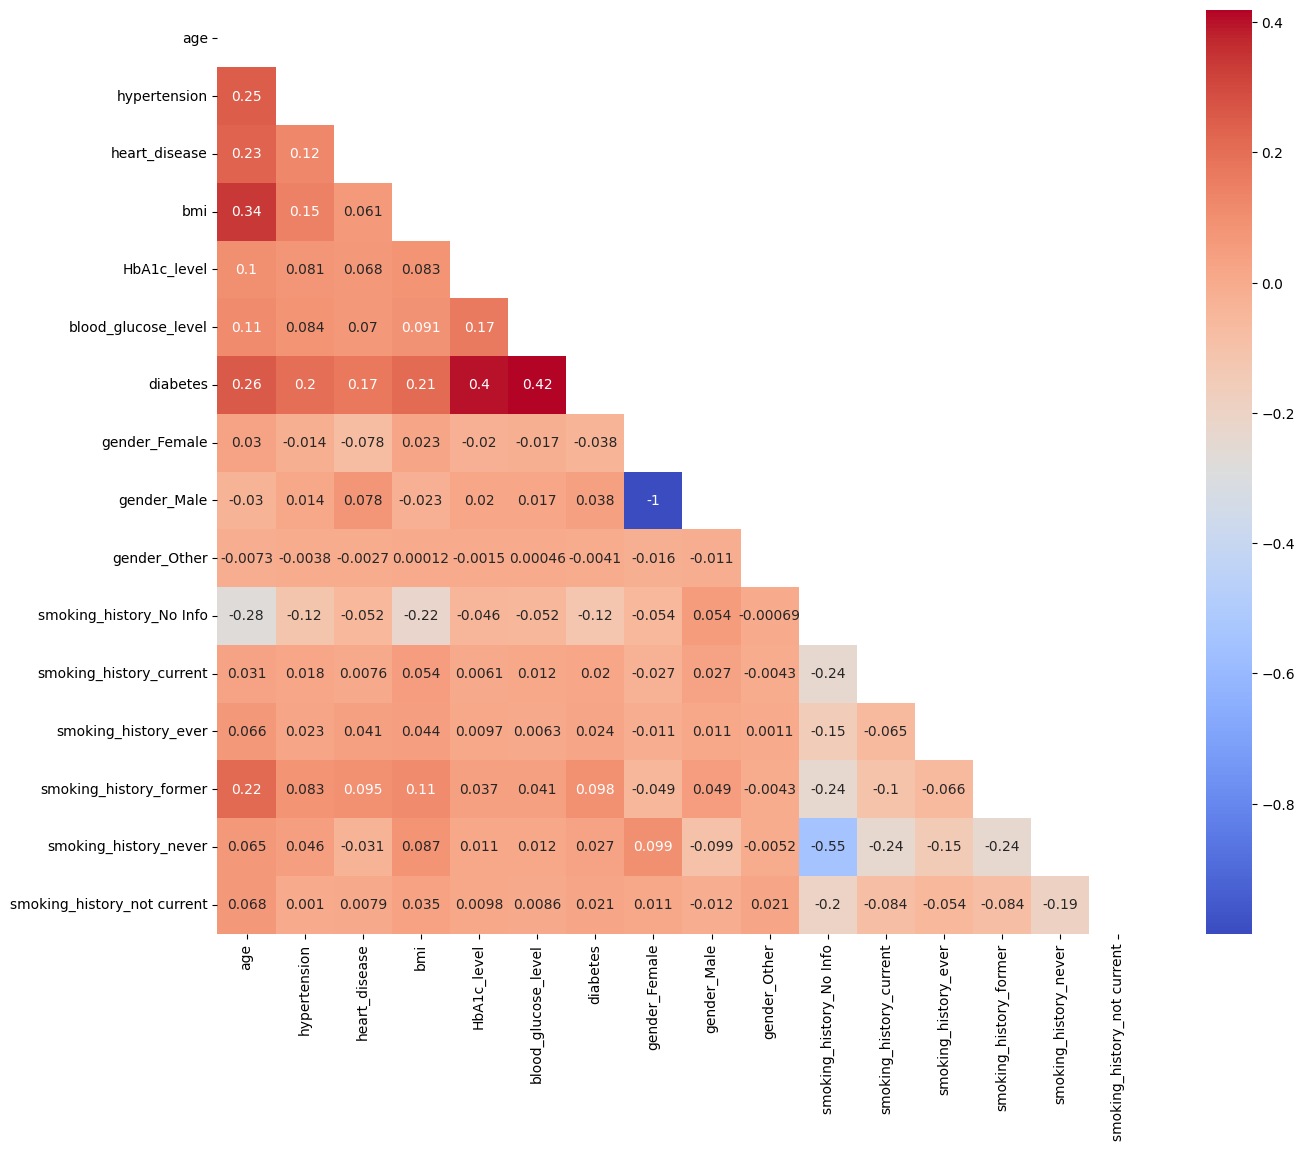

In [25]:
# definimos matriz de correlacion
corr = data.corr(method='pearson')
# Creamos una máscara que filtre la diagonal superior de la matriz (para ignorar duplicados)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
#generamos hotmap con seaborn
plt.figure(figsize=(15,12))
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True)
plt.show()


Analisis de valores de correlacion Negativa Altos  < -0.80
gender_Female y gender_Male: esta es claramente una relacion inversa ya que claramente si un paciente es hombre, no puede ser mujer, por ello indica una correlacion negativa perfecta

Analisis de valores de correlacion Negativa Medios  -0.4 < correlacion < -0.8
Smoking_history_no_Info y Smoking_history_Never: indica que hay una relación inversa moderada entre estas dos variables. Esto significa que si un paciente no tiene información sobre su historial de tabaquismo, es menos probable que nunca haya fumado. Es importante tener en cuenta que no podemos concluir que la falta de información sobre el historial de tabaquismo sea la causa directa de que un paciente haya fumado en el pasado o lo haga actualmente. Pueden haber otros factores que influyan en la relación entre estas dos variables.

Analisis de valores de correlacion media 0.4 < correlacion < 0.8
Diabetes y blood_glucose_level, HbA1c_leve: esta correlacion se peude explciar deido a que son medidas que se hacen en la ansagre para medir su nivel de azucar, existe una correlacion entre ellas, pero no indica siempre que por ello alla diabtes, pueden existir otros factores que influyen en la relacion de estas variables, como las comidas en las ultimas semanas.


**3. Particion de los datos para entrenamiento**

Separaremos los datos, siendo 70% de los datos para entrenamiento y 30% para validacion.

In [26]:
# Importamos las funciones de sklearn
from sklearn.model_selection import train_test_split

# Dividimos los datos en variables de entrada y salida
X = data.drop('diabetes', axis=1)
Y = data['diabetes']

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


**4. Uso de la tecnica de sobre-muestreo**

Como en nuestra variable objetivo existe un claro desbalance, usaremos la tecnica de sobre-muestreo para solucionarlo

In [29]:
# Aplicar sobremuestreo a la clase minoritaria
smote = SMOTE(sampling_strategy='minority', k_neighbors=1, random_state=42)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

In [30]:
#verificamos nuevamente el balance de clases
df_resampled = pd.concat([X_train, Y_train], axis=1)
class_counts = df_resampled['diabetes'].value_counts()

print(class_counts)

diabetes
0    64047
1    64047
Name: count, dtype: int64


**5. Entrenamiento y seleccion de los mejores hiperparametros de cada modelo**

Se va a entrenar a cada modelo, utilizando diferentes valores para sus hiperparametros, usando como metodologia de validacion k-folds. 
Para evaluar cuales son los mejores hiperparametros de cada modelo se evaluara su score, comparandolo con el los datos de entrenamiento clasico y con el de test, de esta forma tambien evaluaremos posibles casos de sobre-entrenamiento.
Modelos:

    -Redes neuronales 

    -Gradient boosting tree 

    -SVM 

**5.1 Redes neuronales**

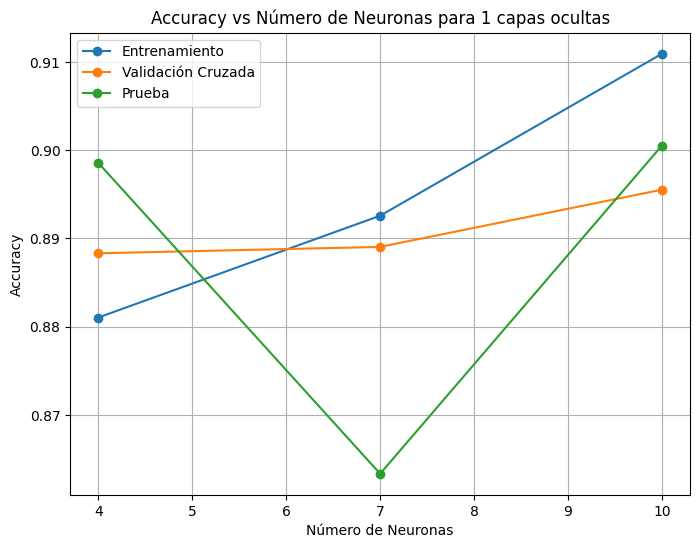

   Número de Neuronas  Entrenamiento  Validación Cruzada    Prueba
0                   4       0.881040            0.888317  0.898567
1                   7       0.892579            0.889042  0.863333
2                  10       0.910940            0.895530  0.900533


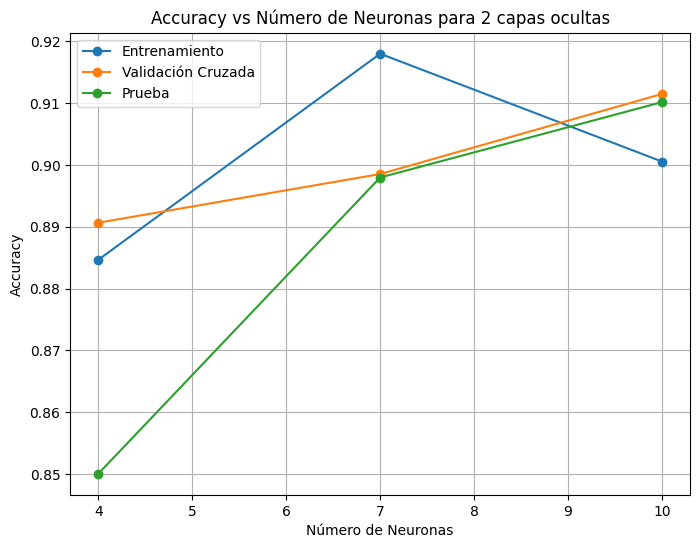

   Número de Neuronas  Entrenamiento  Validación Cruzada    Prueba
0                   4       0.884655            0.890651  0.850033
1                   7       0.917998            0.898528  0.897967
2                  10       0.900550            0.911487  0.910167


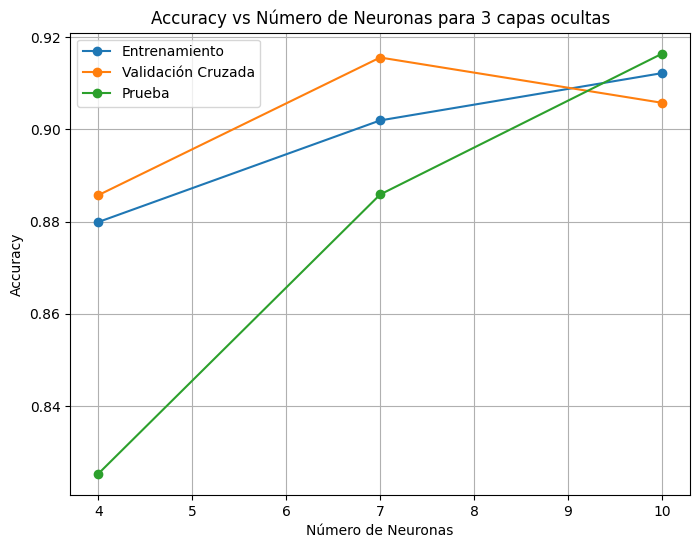

   Número de Neuronas  Entrenamiento  Validación Cruzada    Prueba
0                   4       0.879901            0.885725  0.825367
1                   7       0.901916            0.915546  0.885867
2                  10       0.912158            0.905733  0.916367


In [32]:
neuronas_vector = [4, 7, 10] # Vector con el número de neuronas a probar
capas_vector = [1, 2, 3] # Vector con el número de capas a probar
for capas in capas_vector:
    train_accuracies = []
    cross_val_accuracies = []
    test_accuracies = []
    for neuronas in neuronas_vector:
        model = MLPClassifier(
            hidden_layer_sizes=(neuronas,)*capas,  # 4 capas ocultas con 40 neuronas cada una
            activation='relu',  # Función de activación ReLU
            batch_size=64, # Tamaño del minibatch 
            max_iter=1000, # Número máximo de iteraciones
        )
        #Entrenamiento del modelo 
        model.fit(X_train, Y_train)
        # Calcula el accuracy en el conjunto de entrenamiento
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(Y_train, y_train_pred)
        train_accuracies.append(train_accuracy)

        #Entrenamiento del modelo con validación cruzada
        k = 5 # Número de folds
        n_jobs =  5 # Número de procesos en paralelo
        cv_scores = cross_val_score(model, X_train, Y_train, cv=k, scoring='accuracy', n_jobs=n_jobs)
        # Calcula el accuracy en el conjunto de entrenamiento
        cross_accuracy = cv_scores.mean()
        cross_val_accuracies.append(cross_accuracy)

        # Calcula el accuracy en el conjunto de prueba
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(Y_test, y_test_pred)
        test_accuracies.append(test_accuracy)
        
    plt.figure(figsize=(8, 6))
    plt.plot(neuronas_vector, train_accuracies, label='Entrenamiento', marker='o')
    plt.plot(neuronas_vector, cross_val_accuracies, label='Validación Cruzada', marker='o')
    plt.plot(neuronas_vector, test_accuracies, label='Prueba', marker='o')
    plt.xlabel('Número de Neuronas')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Número de Neuronas para {capas} capas ocultas')
    plt.legend()
    plt.grid()
    plt.show()
    
    table = pd.DataFrame({
    'Número de Neuronas': neuronas_vector,
    'Entrenamiento': train_accuracies,
    'Validación Cruzada': cross_val_accuracies,
    'Prueba': test_accuracies})
    print(table)
        

Intentando maxificar el accuracy y minimizar la diferencia entre los tres puntajes y la complejidad del modelo. el mejor modelo de redes neuronales tiene como hiperparametros : 
Neuronas = 
Capas = 
mini-batch = 64
funcion-activacion ReLu
maximo-iteraciones = 1000


In [ ]:
#metricas de este modelo

**5.2 Gradient boosting tree**

In [16]:
neuronas_vector = [4, 7, 10] # Vector con el número de neuronas a probar
capas_vector = [1, 2, 3] # Vector con el número de capas a probar
for capas in capas_vector:
    train_accuracies = []
    cross_val_accuracies = []
    test_accuracies = []
    for neuronas in neuronas_vector:
        model = MLPClassifier(
            hidden_layer_sizes=(neuronas,)*capas,  # 4 capas ocultas con 40 neuronas cada una
            activation='relu',  # Función de activación ReLU
            batch_size=64, # Tamaño del minibatch 
            max_iter=1000, # Número máximo de iteraciones
        )
        #Entrenamiento del modelo 
        model.fit(X_train, Y_train)
        # Calcula el accuracy en el conjunto de entrenamiento
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(Y_train, y_train_pred)
        train_accuracies.append(train_accuracy)

        #Entrenamiento del modelo con validación cruzada
        k = 5 # Número de folds
        n_jobs =  5 # Número de procesos en paralelo
        cv_scores = cross_val_score(model, X_train, Y_train, cv=k, scoring='accuracy', n_jobs=n_jobs)
        # Calcula el accuracy en el conjunto de entrenamiento
        cross_accuracy = cv_scores.mean()
        cross_val_accuracies.append(cross_accuracy)

        # Calcula el accuracy en el conjunto de prueba
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(Y_test, y_test_pred)
        test_accuracies.append(test_accuracy)
        
    plt.figure(figsize=(8, 6))
    plt.plot(neuronas_vector, train_accuracies, label='Entrenamiento', marker='o')
    plt.plot(neuronas_vector, cross_val_accuracies, label='Validación Cruzada', marker='o')
    plt.plot(neuronas_vector, test_accuracies, label='Prueba', marker='o')
    plt.xlabel('Número de Neuronas')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Número de Neuronas para {capas} capas ocultas')
    plt.legend()
    plt.grid()
    plt.show()
    
    table = pd.DataFrame({
    'Número de Neuronas': neuronas_vector,
    'Entrenamiento': train_accuracies,
    'Validación Cruzada': cross_val_accuracies,
    'Prueba': test_accuracies})
    print(table)
        

AttributeError: 'tuple' object has no attribute 'append'

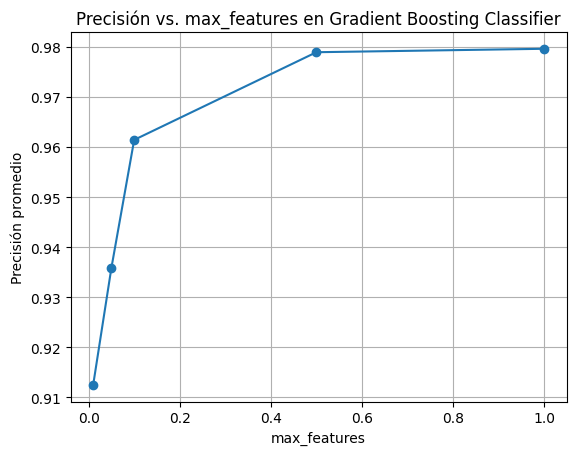

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

accuracy_scores = []
tasa_aprendizaje_vector = [0.01, 0.05, 0.1, 0.5, 1] # Vector con la tasa de aprendizaje a probar

# Entrenar el modelo con diferentes valores de max_features
for tasa_aprendizaje in tasa_aprendizaje_vector:
    clf = GradientBoostingClassifier(max_features=8, random_state=0, n_estimators=100, learning_rate=tasa_aprendizaje)
    scores = cross_val_score(clf, X_train, Y_train, cv=5)  # Validación cruzada de 5 pliegues
    accuracy_scores.append(scores.mean())

# Graficar los resultados
plt.figure()
plt.plot( tasa_aprendizaje_vector, accuracy_scores, marker='o')
plt.title('Precisión vs. max_features en Gradient Boosting Classifier')
plt.xlabel('max_features')
plt.ylabel('Precisión promedio')
plt.grid(True)
plt.show()